### Technical Validation: Step 1 Statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import os
from tqdm import tqdm
import datetime
from chinese_calendar import is_holiday, is_workday

In [2]:
root_path = '/data6/peiyan/SH-METR/results/' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_Demandflow_10.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HO_inFlow,WO_inFlow,CoutFlow,HO_outFlow,WO_outFlow
0,20170501,0,60000,61000,112,29,32,9,15,0,11,13,1
1,20170501,0,60000,61000,113,142,102,40,51,4,30,41,1
2,20170501,0,60000,61000,114,66,35,17,19,7,12,10,2
3,20170501,0,60000,61000,119,23,14,6,9,0,1,3,2
4,20170501,0,60000,61000,124,17,21,2,4,2,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,1,8,6,4
3788888,20170831,12545,225000,230000,2054,18,110,5,2,6,19,39,12
3788889,20170831,12545,225000,230000,2055,5,80,0,1,2,19,23,6
3788890,20170831,12545,225000,230000,2056,33,99,8,4,1,20,31,6


1. fig A

In [3]:
def drawFigA():

    figAWorkdayResults = {}
    figAHolidayResults = {}
    start_hour = 6 # start from 8:00
    end_hour = 23  # end in 23:00

    for i in range(start_hour, end_hour):
        figAWorkdayResults[i] = []
        figAHolidayResults[i] = []

    curr_date = 20170501
    abnormal_date = [20170504, 20170508, 20170509, 20170616, 20170627, 20170628]
    date_cache = [ 0 for i in range(end_hour - start_hour)]

    for line in tqdm(raw_data.values):
        if line [0] in abnormal_date:
            continue

        if curr_date != line[0]:
            if is_workday(datetime.datetime.strptime(str(curr_date),"%Y%m%d")):
                for hour in range(end_hour - start_hour):
                    figAWorkdayResults[hour+start_hour].append(date_cache[hour])
            else:
                for hour in range(end_hour - start_hour):
                    figAHolidayResults[hour+start_hour].append(date_cache[hour])
            
            curr_date = line [0]
            date_cache = [ 0 for i in range(end_hour - start_hour)]

        curr_hour = line[2]//10000
        if curr_hour >= start_hour and curr_hour < end_hour:
            date_cache[curr_hour - start_hour] += line[5]

    # Last Day
    if is_workday(datetime.datetime.strptime(str(curr_date),"%Y%m%d")):
        for hour in range(end_hour - start_hour):
            figAWorkdayResults[hour+start_hour].append(date_cache[hour])
    else:
        for hour in range(end_hour - start_hour):
            figAHolidayResults[hour+start_hour].append(date_cache[hour])
            

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.dpi = 500

    colors = ['#8A4B43','#B12222','#FF4400','#FEA600','#FFE100','#DEB887','#F5E7BC','#2E8A57','#9BCD31','#20B3AA','#B0E1E7','#1963B3','#789CF2','#3B63E6','#E3E3E3','#696969','#0C0C0C']

    workdayplot = ax1.boxplot(x=list(figAWorkdayResults.values()),tick_labels = list(figAWorkdayResults.keys()),patch_artist=True,showfliers=False,showmeans=False, medianprops=dict(linewidth=0), zorder=0)
    for i, data in enumerate(list(figAWorkdayResults.values())): # draw datapoints
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        data = [ np.mean(data) if i<10000 else i for i in data ] # conceal missing point
        ax1.scatter(x_positions, data, color='black', alpha=0.6, s=0.3, zorder=1) 
    for patch, color in zip(workdayplot['boxes'], colors):  # set box colors
        patch.set_facecolor(color)
    medians_box = [] # draw medians curve
    for median in workdayplot['medians']:  
        # median.set(color='white', linewidth=1) 
        medians_box.append(median.get_ydata()[0])
    ax1.plot(list(range(1,end_hour-start_hour+1)), medians_box, linewidth=0.5, color='black', linestyle='--', marker='^', markersize=0.5)
    ax1.set_title('Workday',fontsize=20)
    ax1.set_xlabel('Hour',fontsize=15)
    ax1.set_ylabel('#Ridership',fontsize=15)
    ax1.set_ylim(0, 1.1e6)
    ax1.set_xticks(range(1, end_hour-start_hour+1, 2))
    ax1.set_xticklabels([list(figAWorkdayResults.keys())[i] for i in range(0, end_hour-start_hour, 2)])
    ax1.tick_params(labelsize=12)


    holidayplot = ax2.boxplot(x=list(figAHolidayResults.values()), tick_labels = list(figAHolidayResults.keys()) ,patch_artist=True, showfliers=False, showmeans=False, medianprops=dict(linewidth=0),zorder=0)
    for i, data in enumerate(list(figAHolidayResults.values())):
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        ax2.scatter(x_positions, data, color='black', alpha=0.6, s=0.3, zorder=1) 
    for patch, color in zip(holidayplot['boxes'], colors):
        patch.set_facecolor(color)
        medians_box = [] # draw medians curve
    for median in holidayplot['medians']:  
        # median.set(color='white', linewidth=1) 
        medians_box.append(median.get_ydata()[0])
    ax2.plot(list(range(1,end_hour-start_hour+1)), medians_box, linewidth=0.5, color='black', linestyle='--', marker='^', markersize=0.5)
    ax2.set_title('Non-Workday', fontsize=20)
    ax2.set_xlabel('Hour',fontsize=15)
    ax2.set_ylabel('#Ridership',fontsize=15)
    ax2.set_ylim(0, 1.1e6)
    ax2.set_xticks(range(1,end_hour-start_hour+1, 2))
    ax2.set_xticklabels([list(figAHolidayResults.keys())[i] for i in range(0, end_hour-start_hour, 2)])
    ax2.tick_params(labelsize=12)

    fig.savefig('../results/totalFlow.pdf', dpi=300)
    
    return figAWorkdayResults, figAHolidayResults

100%|██████████| 3788892/3788892 [00:04<00:00, 784502.29it/s]


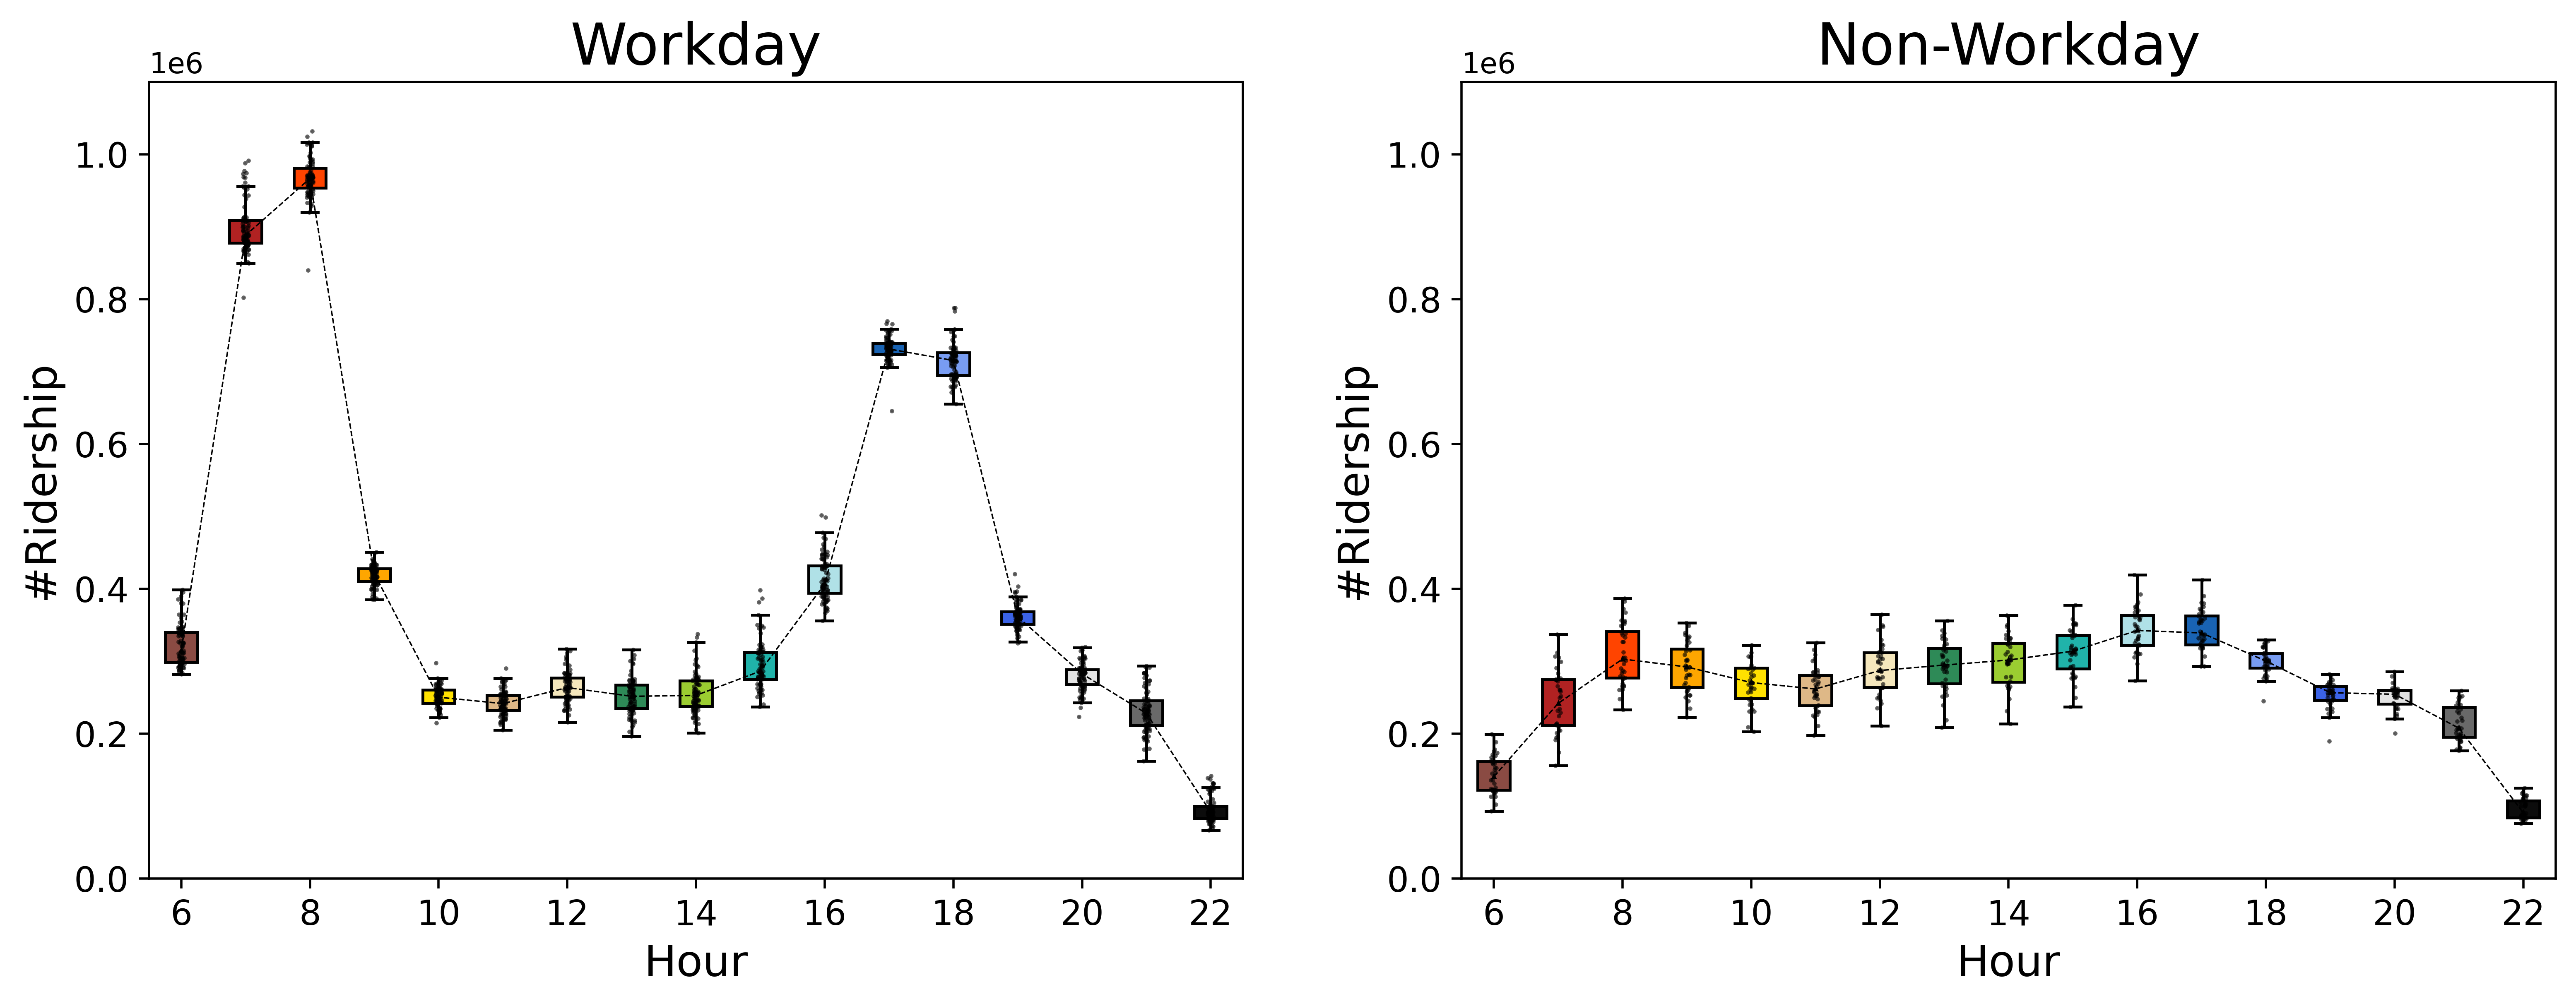

In [4]:
figAWorkdayResults, figAHolidayResults = drawFigA()